In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gpflow.utilities import print_summary, set_trainable, to_default_float
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from sklearn.metrics import mean_squared_error, mean_absolute_error

import sys
sys.path.append('../../src')
from data_preparation import get_birth_data, separate_data

In [2]:
# load data

# whole dataset
data = get_birth_data()
x, y = separate_data(data, train_test=False)

# train/test split
df_train = pd.read_csv('../../data/train.csv')
x_train, y_train = separate_data(df_train)
df_test = pd.read_csv('../../data/test.csv')
x_test, y_test = separate_data(df_test)

# get date for x-axis in plots
def get_xticks(data):
    idss = []; yrs = []
    yr = 1969
    for i in range(20):
        df = data.loc[data.year == yr+i]
        yrs.append(yr+i)
        idss.append(df.index[0])
    return idss, yrs
pos, labels = get_xticks(data)
pos_train, labels_train = get_xticks(df_train)
pos_test, labels_test = get_xticks(df_test)

2022-08-01 20:37:46.927598: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-01 20:37:47.536131: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9646 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5


# Additive model:  two-latent functions

        y = f(x) + g(x) + e
        f = GP(0, RBF)
        g = GP(0, Periodic)

In [3]:
# function to plot results

def plot_distribution(X, Y, mean, var, pos, labels):
    plt.figure(figsize=(25, 7))

    plt.plot(X, Y, '.', color="black", alpha=0.5, markersize=3)
    plt.plot(X, mean, color="C0")
    c = 1.96 * np.sqrt(var)
    plt.fill_between(X[:,0], (mean - c)[:,0], (mean + c)[:,0], alpha=0.2, edgecolor='gray', facecolor='C0')

    plt.xticks(pos, labels)
    plt.xlabel('Date', fontsize=15)
    plt.ylabel('Normalised Births', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()
    plt.close()

Noise variance is not trained.

2022-08-01 20:39:34.821880: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-08-01 20:39:40.795603: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x765d410


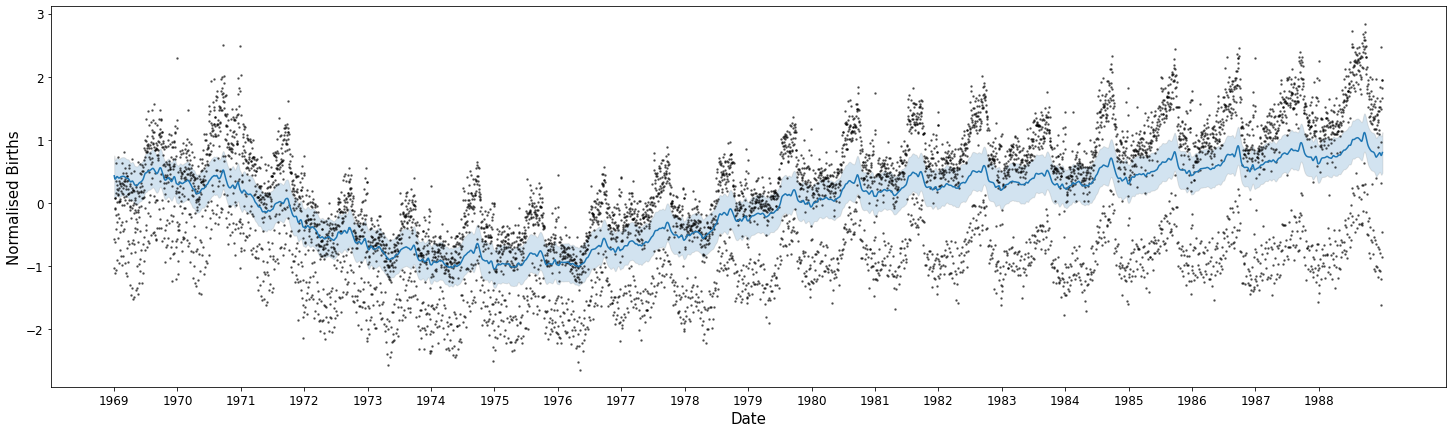

Fitted values MSE:  17789856.539261747
Log-marginal likelihood:  -9159.317977588624


In [4]:
# build model & compute fitted values

kernel = gpflow.kernels.RBF() + gpflow.kernels.Periodic(gpflow.kernels.RBF())

model = gpflow.models.GPR(data=(x, y), kernel=kernel, mean_function=None)
set_trainable(model.likelihood.variance , False)

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(model.training_loss, model.trainable_variables)

mean, var = model.predict_f(x)

plot_distribution(x, y, mean, var, pos, labels)

print('Fitted values MSE: ', mean_squared_error(x, mean))
print('Log-marginal likelihood: ', model.log_marginal_likelihood().numpy())

print_summary(model, fmt='notebook')

Not a very good fit. The period parameter value doesn't really make sense. Should be yearly periodic.

Set period to mean average of days per year and don't train it.

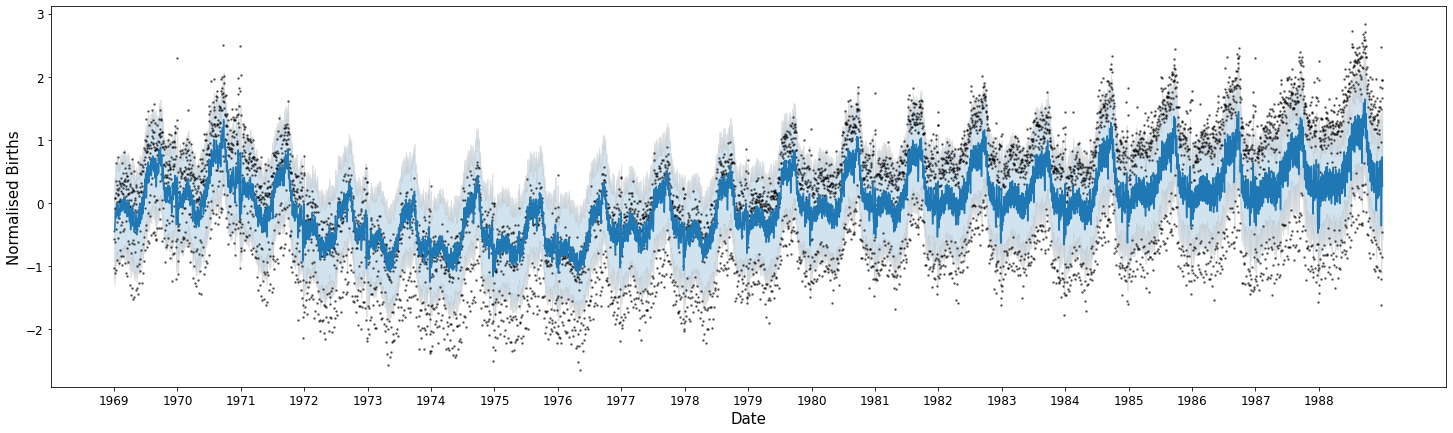

Fitted values MSE:  17790392.261935893
Log-marginal likelihood:  -9674.272486034979


In [5]:
# re-build model & set period

kernel = gpflow.kernels.RBF() + gpflow.kernels.Periodic(gpflow.kernels.RBF(), period=365.25)

model = gpflow.models.GPR(data=(x, y), kernel=kernel, mean_function=None)
set_trainable(model.likelihood.variance , False)
set_trainable(model.kernel.kernels[1].period , False)

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(model.training_loss, model.trainable_variables)

mean, var = model.predict_f(x)

plot_distribution(x, y, mean, var, pos, labels)

print('Fitted values MSE: ', mean_squared_error(x, mean))
print('Log-marginal likelihood: ', model.log_marginal_likelihood().numpy())

print_summary(model, fmt='notebook')

Worse fit !!! The CI is also not good enough(?)

Add priors to penalised small length scales. 

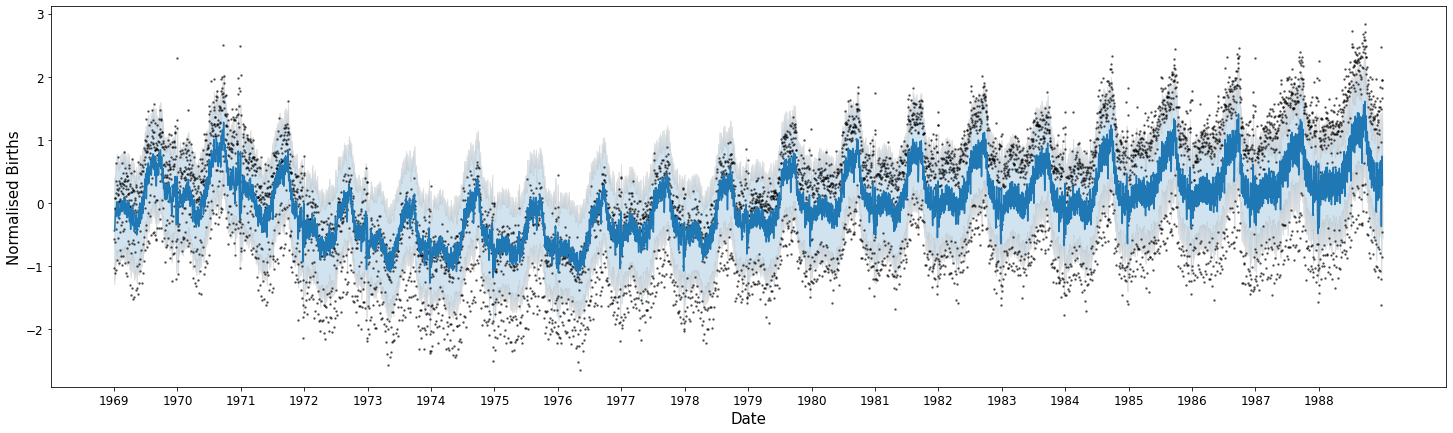

Fitted values MSE:  17790387.58174304
Log-marginal likelihood:  -9675.879666018072


In [6]:
# add prior to hyperparameters

kernel = gpflow.kernels.RBF() + gpflow.kernels.Periodic(gpflow.kernels.RBF(), period=365.25)

model = gpflow.models.GPR(data=(x, y), kernel=kernel, mean_function=None)
set_trainable(model.likelihood.variance , False)
set_trainable(model.kernel.kernels[1].period , False)

# adding priors
model.kernel.kernels[0].lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(2), to_default_float(3))
model.kernel.kernels[0].variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))
model.kernel.kernels[1].base_kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(2), to_default_float(3))
model.kernel.kernels[1].base_kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(model.training_loss, model.trainable_variables)

mean, var = model.predict_f(x)

plot_distribution(x, y, mean, var, pos, labels)

print('Fitted values MSE: ', mean_squared_error(x, mean))
print('Log-marginal likelihood: ', model.log_marginal_likelihood().numpy())

print_summary(model, fmt='notebook')

No improvement. Maybe starting conditions will generate better fit.

Investigate how the hyperparameter starting point affects the fitting of the model.

### Sensitivity Analysis

In [8]:
# automate the process

def optimise_predict_model(kernel):
    
    model = gpflow.models.GPR(data=(x, y), kernel=kernel, mean_function=None)
    set_trainable(model.likelihood.variance , False)
    set_trainable(model.kernel.kernels[1].period , False)

    model.kernel.kernels[0].lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(2), to_default_float(3))
    model.kernel.kernels[0].variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))
    model.kernel.kernels[1].base_kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(2), to_default_float(3))
    model.kernel.kernels[1].base_kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))
    
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(model.training_loss, model.trainable_variables)

    mean, var = model.predict_f(x)

    print('Fitted values MSE: ', mean_squared_error(x, mean))
    print('Log-marginal likelihood: ', model.log_marginal_likelihood().numpy())

    plot_distribution(x, y, mean, var, pos, labels)

    print_summary(model, fmt='notebook')


On both lengthscales but not on variances

Starting Values (l0, l1):  1 1
Fitted values MSE:  17790387.58174304
Log-marginal likelihood:  -9675.879666018072


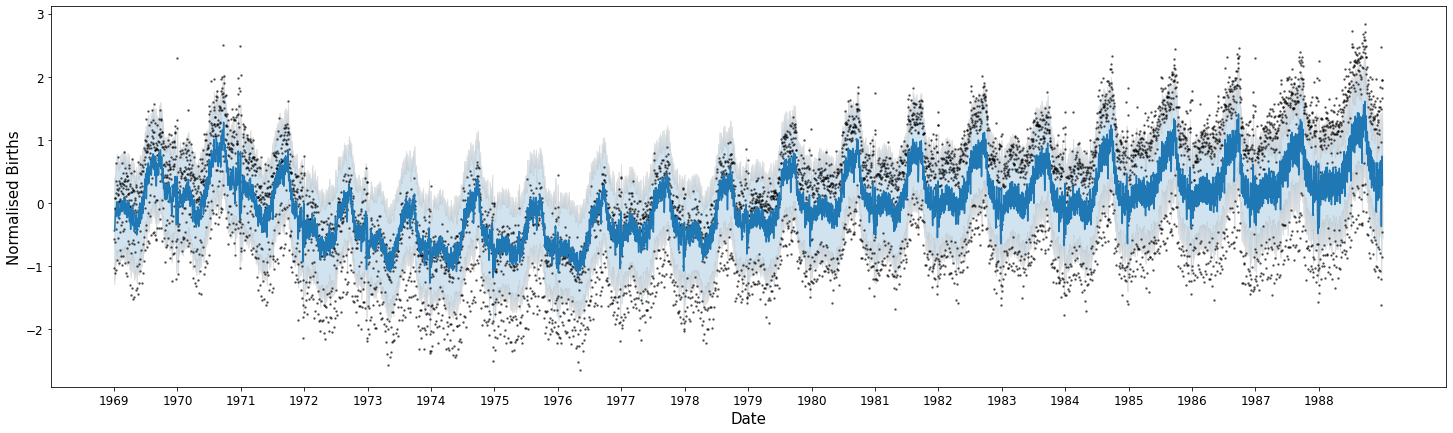

-------------------------------------------------------
Starting Values (l0, l1):  1 5
Fitted values MSE:  17789817.10688124
Log-marginal likelihood:  -8832.996373677248


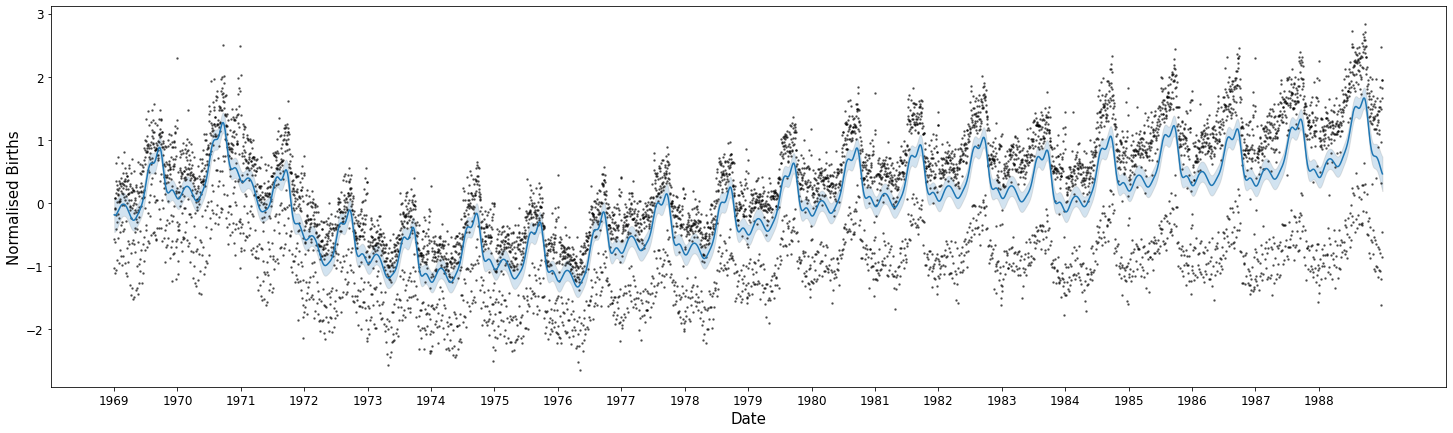

-------------------------------------------------------
Starting Values (l0, l1):  5 1
Fitted values MSE:  17789817.11381216
Log-marginal likelihood:  -8832.998966801333


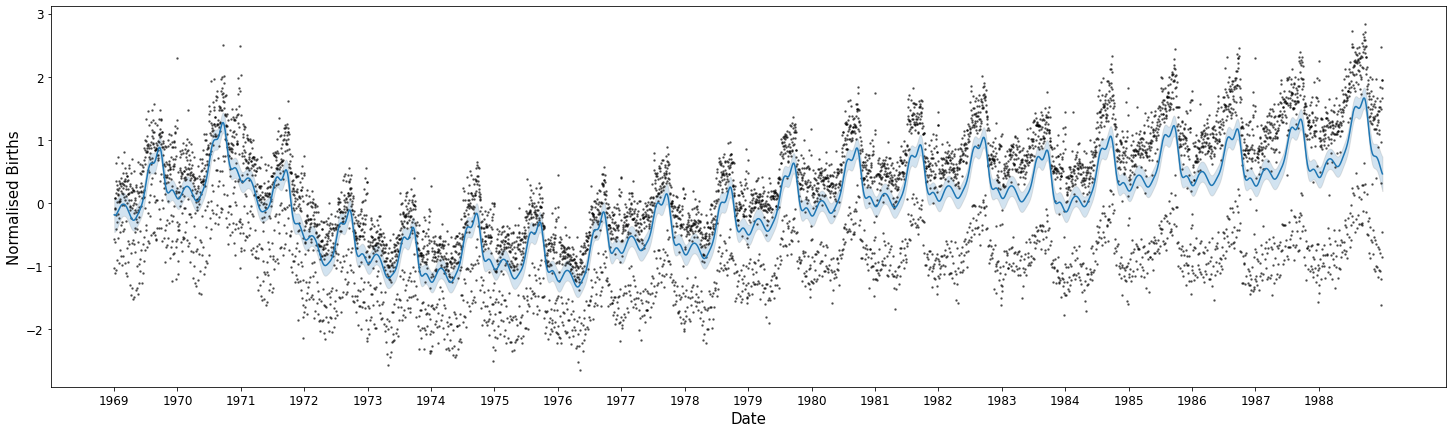

-------------------------------------------------------
Starting Values (l0, l1):  5 5
Fitted values MSE:  17789817.110200856
Log-marginal likelihood:  -8832.998667332991


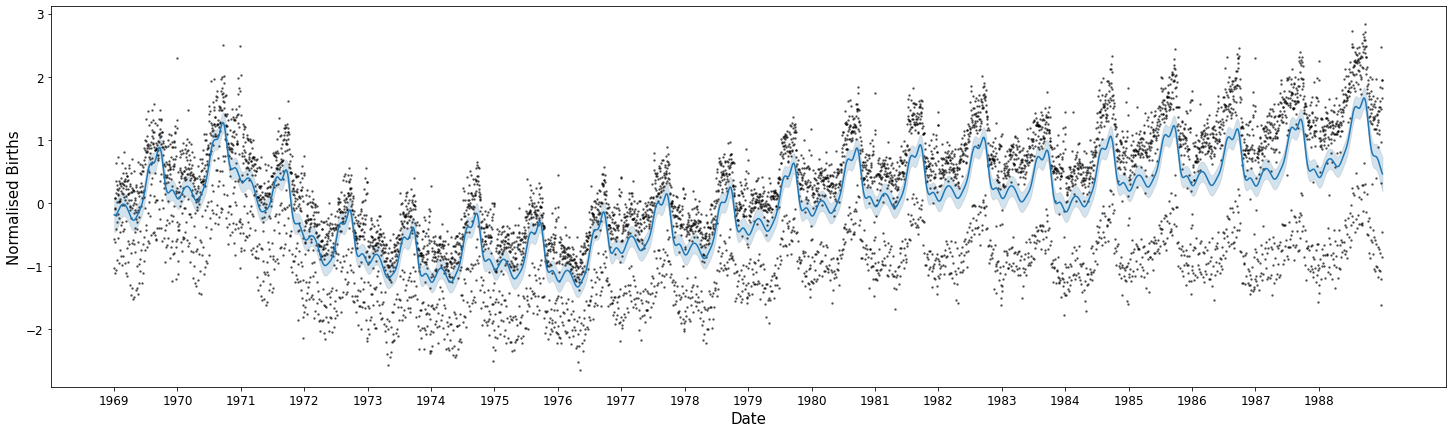

-------------------------------------------------------


In [13]:
starting_values_l0 = [1, 5]
starting_values_l1 = [1, 5]
#starting_values_v = [1]

for l0 in starting_values_l0:
    #for v in starting_values_v:
    for l1 in starting_values_l1:
        print('Starting Values (l0, l1): ', l0, l1)
        kernel = gpflow.kernels.RBF(lengthscales=l0) + gpflow.kernels.Periodic(gpflow.kernels.RBF(lengthscales=l1), period=365.25)
        optimise_predict_model(kernel)
        print('-------------------------------------------------------')

So FOR THE RBF + PERIODIC KERNEL we have found 2 local minima again.

-------------------------------------------------------------

# Train / Test split: model selection

Assess which kernel helps represent the data best.

    MSE, MAE, Likelihood

Since we have found that the starting point of kernel parameters affects the fit significantly, we will first select the kernel and then run an analysis to find optimal starting conditions for hyperparameters.

In [14]:
def optimise_predict_model(model):
    print_summary(model, fmt='notebook')
    
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(model.training_loss, model.trainable_variables)

    mean_train, var_train = model.predict_f(x_train)
    mean_test, var_test = model.predict_f(x_test)

    print('Train')
    plot_distribution(x_train, y_train, mean_train, var_train, pos, labels)
    print('Test')
    plot_distribution(x_test, y_test, mean_test, var_test, pos, labels)

    print_summary(model, fmt='notebook')
    print('Log-marginal likelihood: ', model.log_marginal_likelihood().numpy())
    print('train MSE, MAE: ', mean_squared_error(y_train, mean_train), mean_absolute_error(y_train, mean_train))
    print('test MSE, MAE: ', mean_squared_error(y_test, mean_test), mean_absolute_error(y_test, mean_test))

The models consist of a single latent function, untrainable noise variance (justify), hyperparameters with priors.

Train


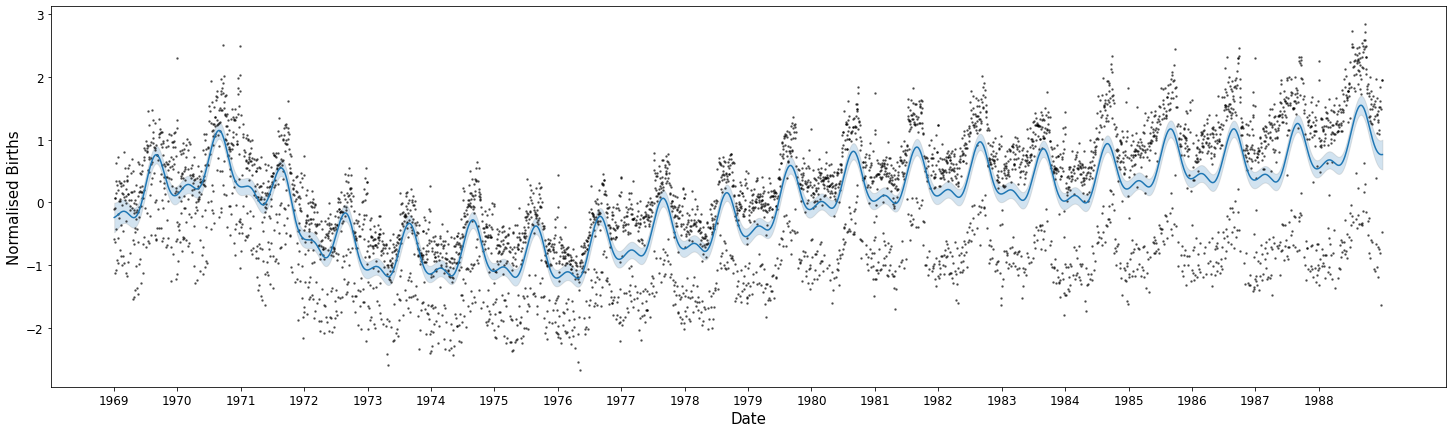

Test


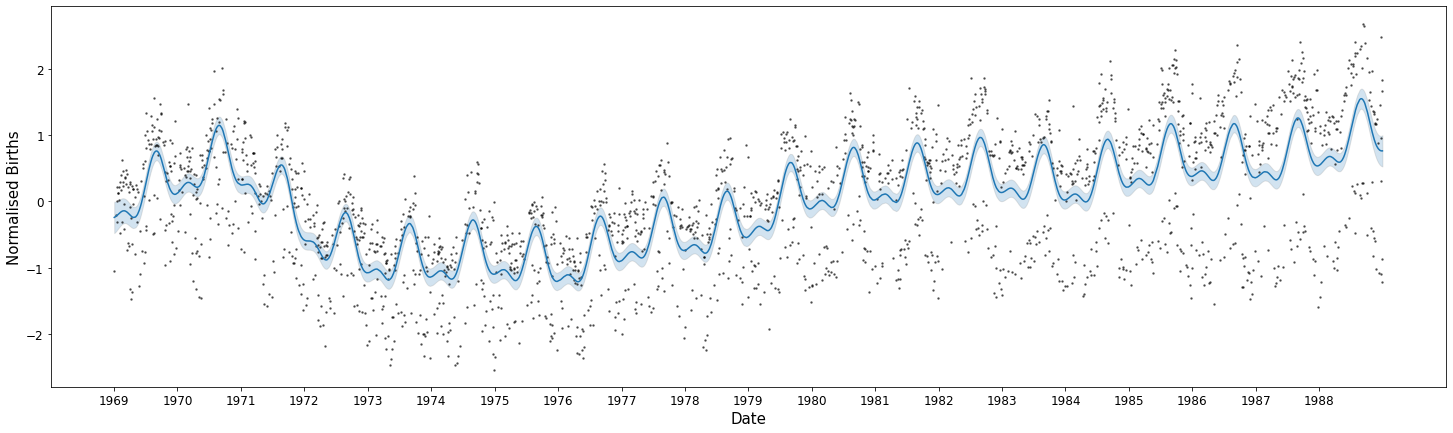

Log-marginal likelihood:  -6200.862250599513
train MSE, MAE:  0.5653177757707049 0.6297995623226523
test MSE, MAE:  0.5813402719414237 0.6384043024587898
--------------------------------------------------------


Train


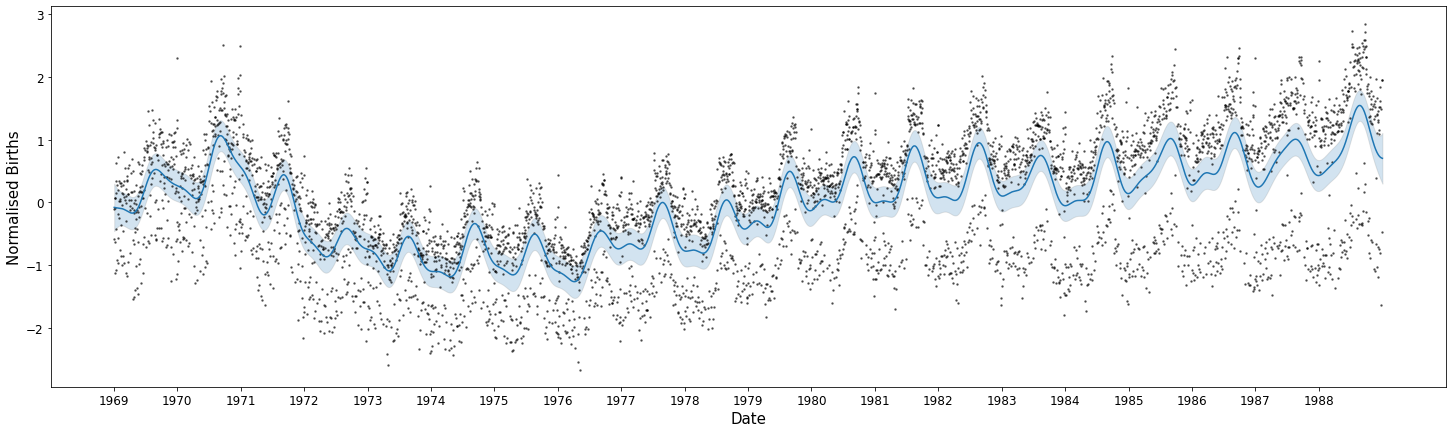

Test


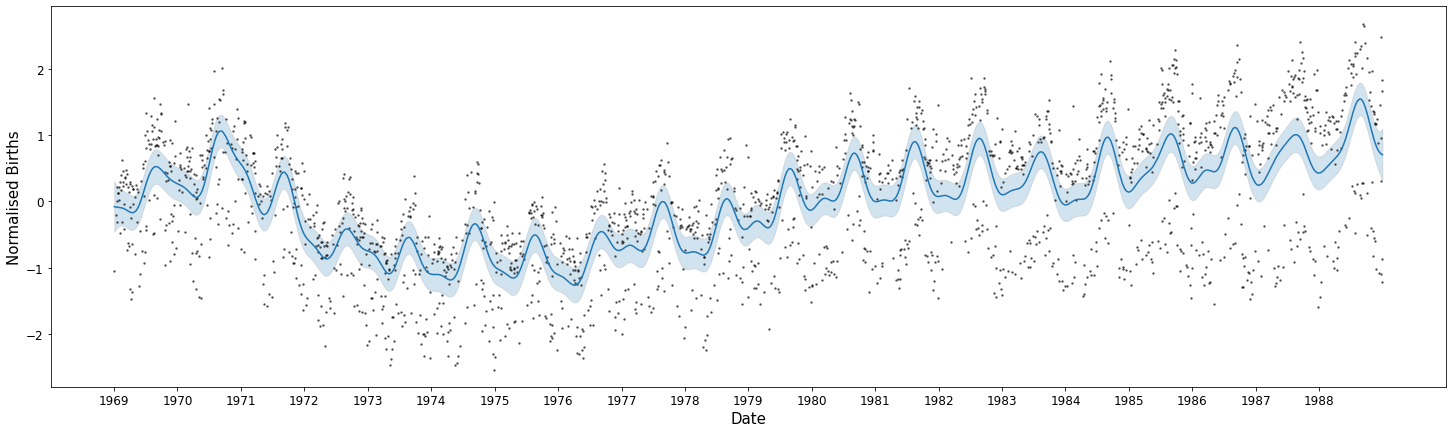

Log-marginal likelihood:  -6260.843164111441
train MSE, MAE:  0.5555225066471007 0.6271882358299563
test MSE, MAE:  0.5890958466905079 0.6456976247720239
--------------------------------------------------------


Train


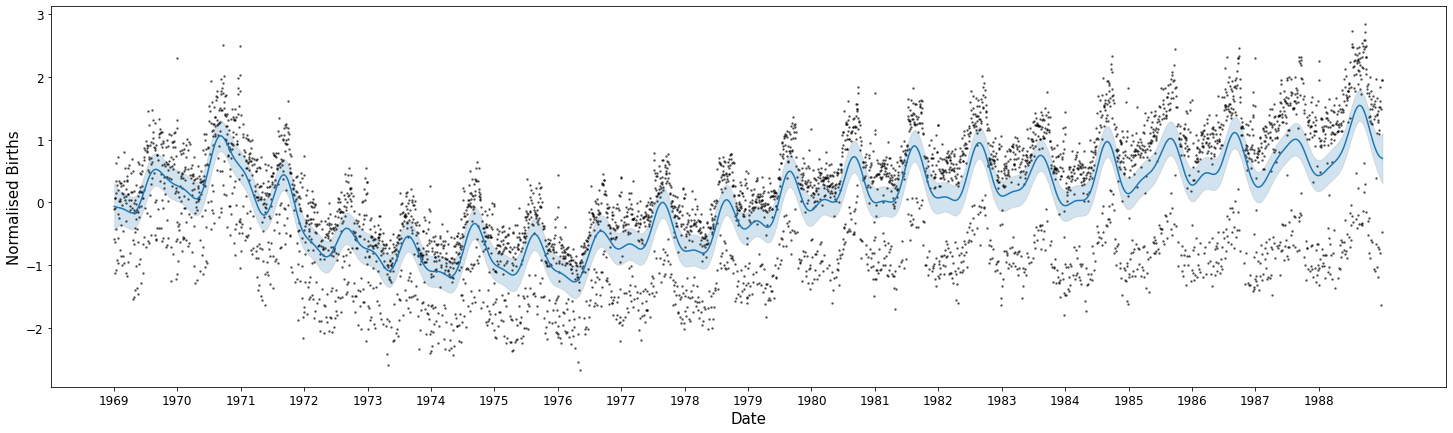

Test


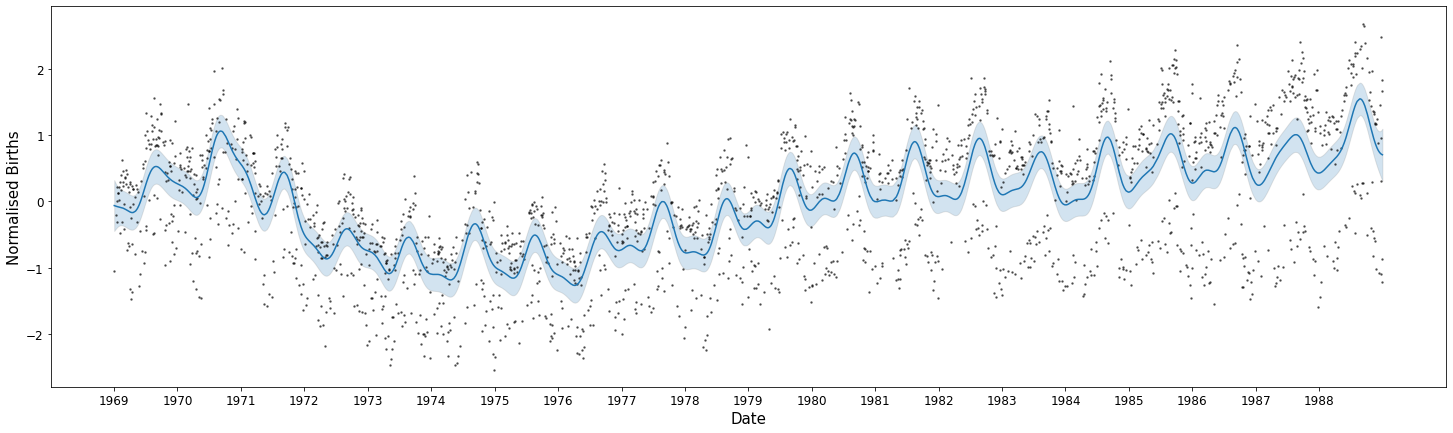

Log-marginal likelihood:  -6260.618811190431
train MSE, MAE:  0.5555320530544543 0.6272063882584161
test MSE, MAE:  0.5891268827419233 0.6457248955138765
--------------------------------------------------------


In [16]:
# Kernel MODEL SELECTION
kernel_list = [gpflow.kernels.Periodic(gpflow.kernels.RBF(), period=365.25), gpflow.kernels.Matern52(), gpflow.kernels.RBF()]

for i in range(len(kernel_list)):
    print(kernel_list[i])

    kernel = gpflow.kernels.RBF() + kernel_list[i]

    model = gpflow.models.GPR(data=(x_train, y_train), kernel=kernel, mean_function=None)
    set_trainable(model.likelihood.variance , False)

    if i == 0:
        set_trainable(model.kernel.kernels[1].period , False)
        model.kernel.kernels[1].base_kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(2), to_default_float(3))
        model.kernel.kernels[1].base_kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))
    else:
        model.kernel.kernels[0].lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(2), to_default_float(3))
        model.kernel.kernels[0].variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))
    
    optimise_predict_model(model)
    print('--------------------------------------------------------')

The kernel with best performance: periodic. RBF and matern perform similarly

Now, we would carry out the sensitivity analysis done before but on the train test set.

Starting Values (l0, l1):  1 1


Train


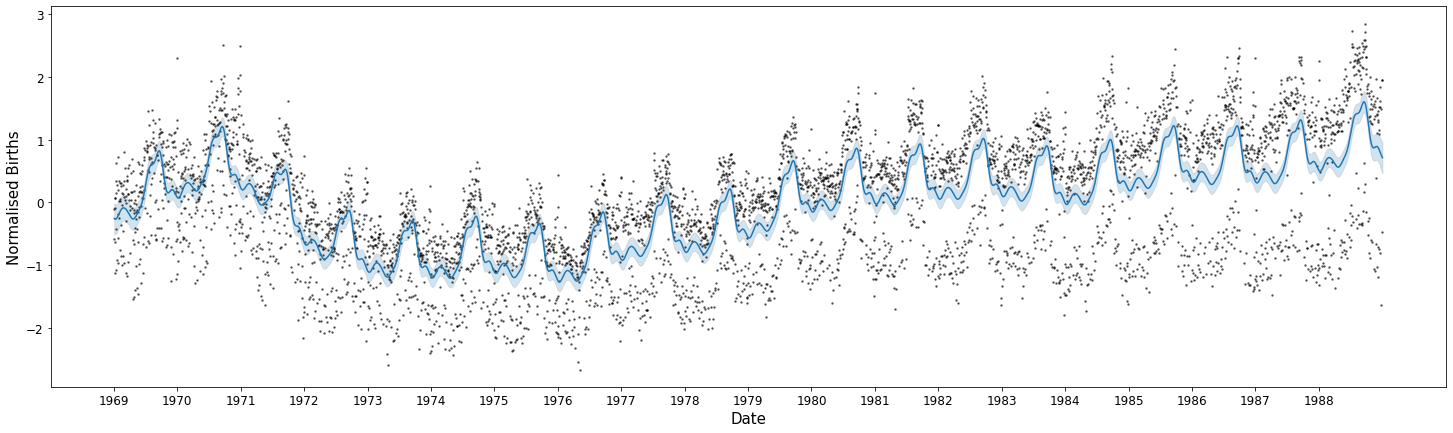

Test


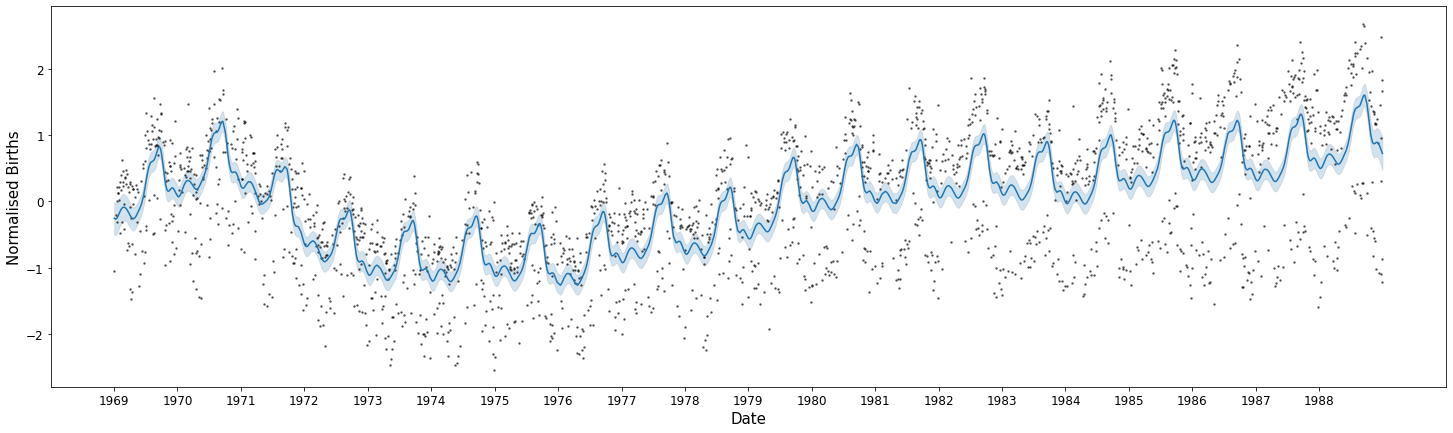

Log-marginal likelihood:  -6195.811606838014
train MSE, MAE:  0.5588388336268951 0.6287428454827128
test MSE, MAE:  0.5753256610812166 0.6372601611986132
--------------------------------------------------------
Starting Values (l0, l1):  1 5


Train


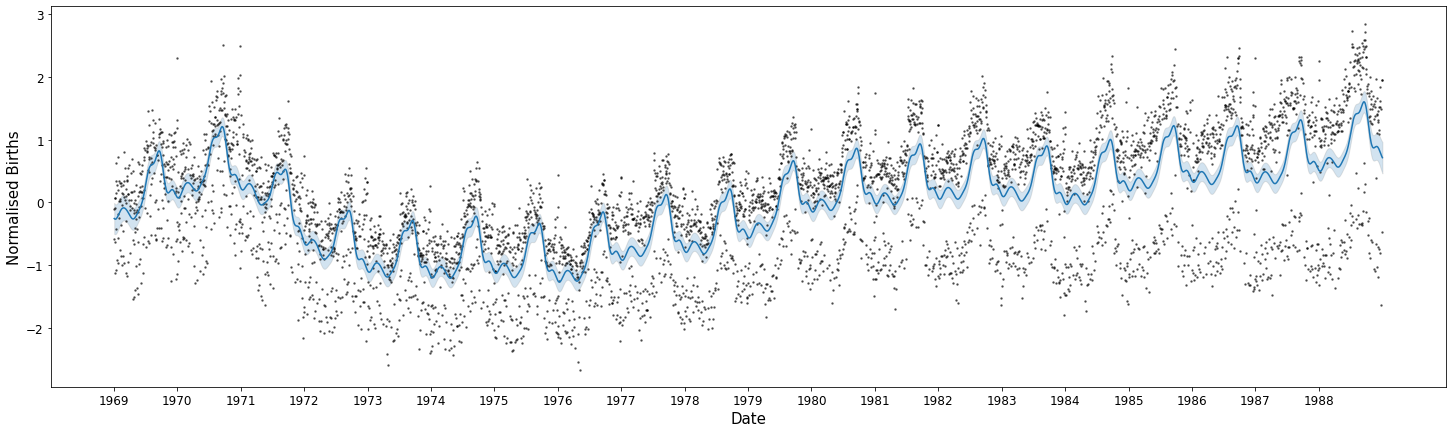

Test


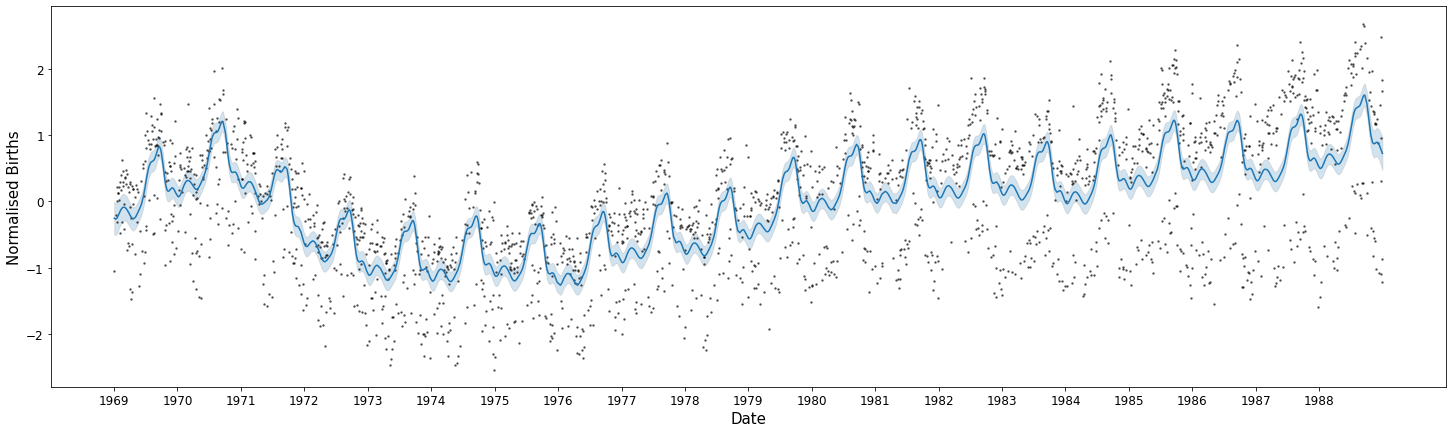

Log-marginal likelihood:  -6195.811700359679
train MSE, MAE:  0.5588387420300108 0.6287428256893062
test MSE, MAE:  0.5753256031850253 0.6372601346533575
--------------------------------------------------------
Starting Values (l0, l1):  5 1


Train


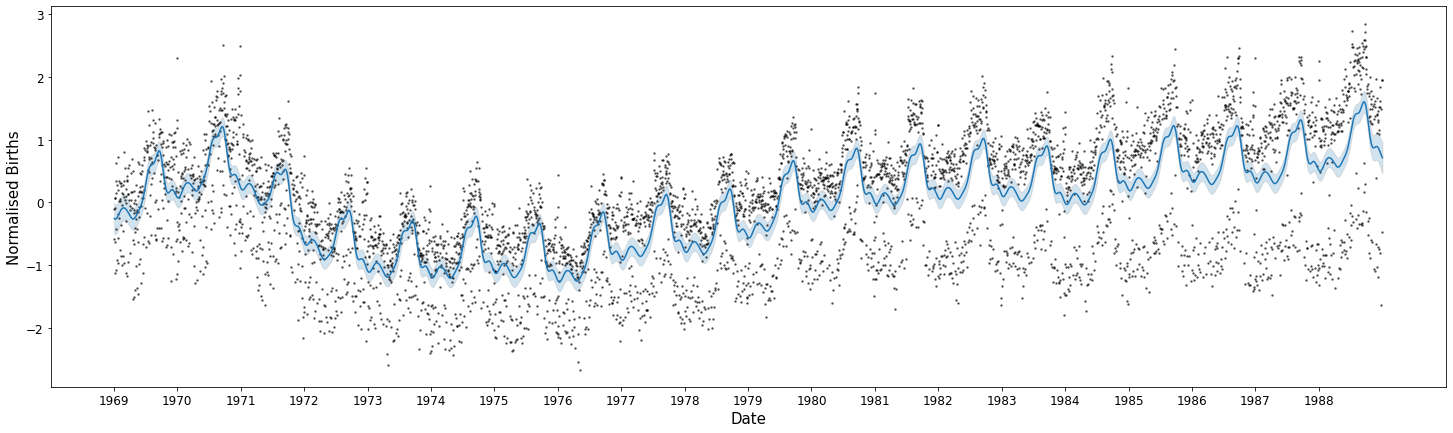

Test


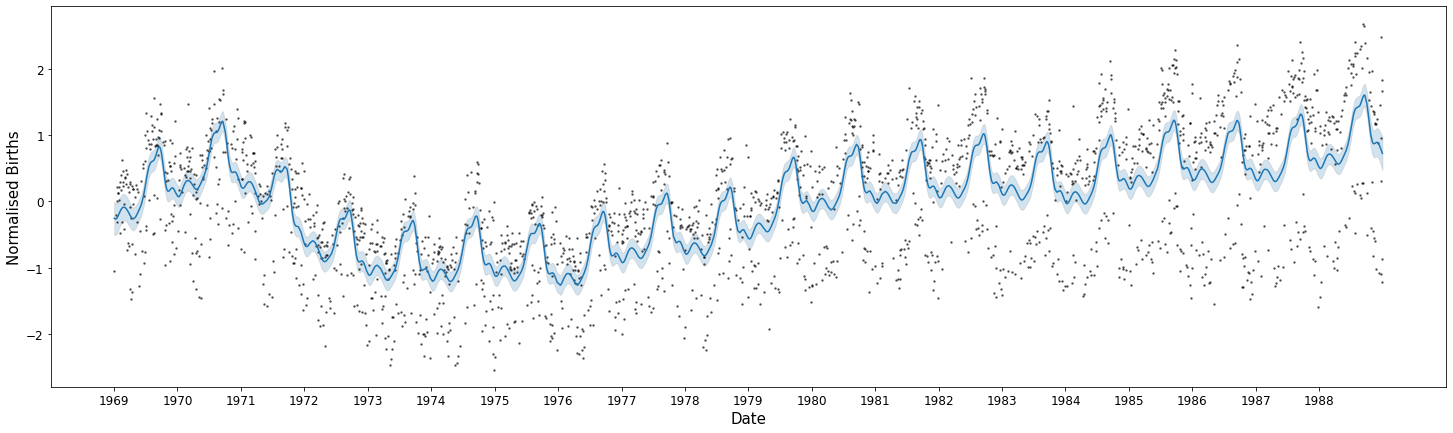

Log-marginal likelihood:  -6195.8112320843875
train MSE, MAE:  0.558839238442118 0.6287429858012622
test MSE, MAE:  0.5753258389193087 0.6372602631633034
--------------------------------------------------------
Starting Values (l0, l1):  5 5


Train


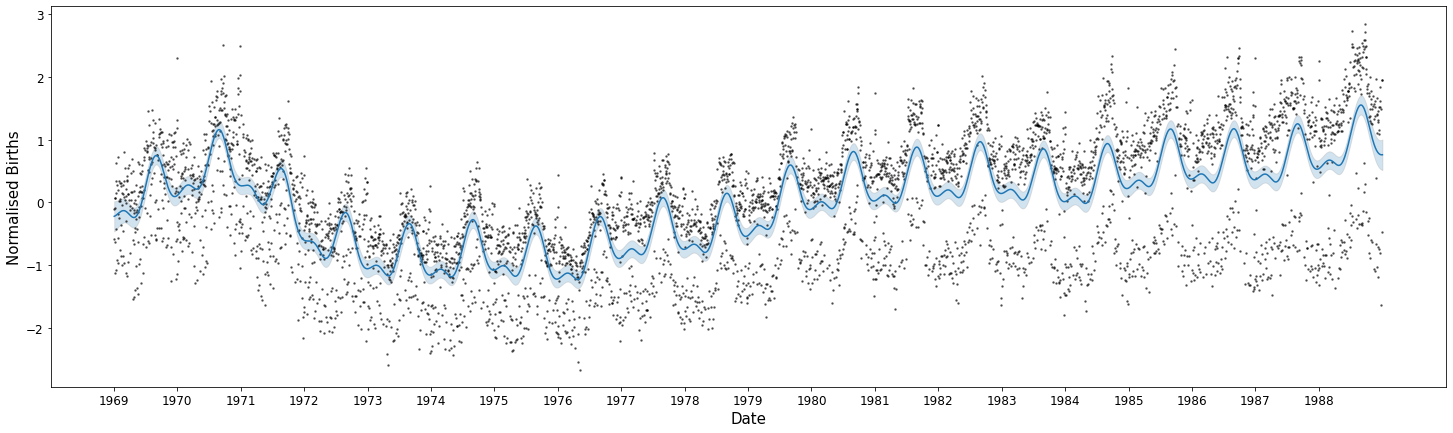

Test


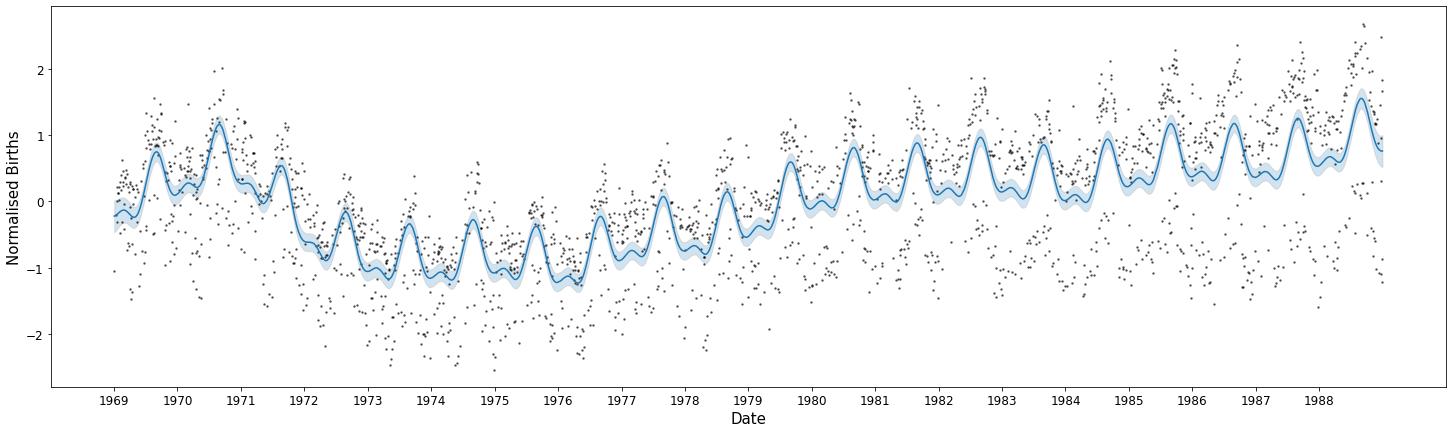

Log-marginal likelihood:  -6200.950346716751
train MSE, MAE:  0.5645574281101021 0.6295844444036367
test MSE, MAE:  0.5808772257118644 0.6381418701902475
--------------------------------------------------------


In [17]:
starting_values_l0 = [1, 5]
starting_values_l1 = [1, 5]

for l0 in starting_values_l0:
    for l1 in starting_values_l1:
        print('Starting Values (l0, l1): ', l0, l1)
        kernel = gpflow.kernels.RBF(lengthscales=l0) + gpflow.kernels.Periodic(gpflow.kernels.RBF(lengthscales=l1), period=365.25)
        model = gpflow.models.GPR(data=(x_train, y_train), kernel=kernel, mean_function=None)
        set_trainable(model.likelihood.variance , False)
        set_trainable(model.kernel.kernels[1].period , False)

        model.kernel.kernels[0].lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(2), to_default_float(3))
        model.kernel.kernels[0].variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))
        model.kernel.kernels[1].base_kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(2), to_default_float(3))
        model.kernel.kernels[1].base_kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))

        optimise_predict_model(model)
        print('--------------------------------------------------------')

There is almost no difference in the fit when using different starting conditions. (5,5) gives a bit worse fit.

Why is this the case in the train/test experiment but not so in the case where we work with the whole dataset ???